In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np 
from openbb import obb
from datetime import date
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from datetime import date
import warnings
warnings.filterwarnings('ignore')

obb.user.preferences.output_type = 'dataframe'

In [52]:
tickers = [
    "AAPL", # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "AMZN",  # Amazon.com Inc.
    "META",  # Meta Platforms Inc.
    "NVDA",  # NVIDIA Corporation
    "TSLA",  # Tesla Inc.
    "JPM",   # JPMorgan Chase & Co.
    "V",     # Visa Inc.
    "AMD", # AMD 
    "KO", # Coca Cola
    "SBUX", #Starbucks
    "PEP", # Pepsi
    "GE", # General Electric
    "GM", # General Motors
    "NFLX", # Netflix
    "RBLX", # Roblox
    "SONY", # Sony
    "WMT", # Walmart
    "IBM", # IBM
    "TGT", # target
    "COF" ,# Capital One,
    "PLTR", # Palantir,
    "MELI", # MercadoLibre
    "ROAD", #Construction
    "QUBT", # Quantum Computing
    "SHOP", # Shopify
    "ADBE" ,# Adobe
    "BRK-B",# berkshire hathaway
    "OKLO", # Oklo Inc
    "SMR", # Nuscale Power Corp
    "HOOD", # Robinhood 
    "GIL", # gildan
    "SPY" # SP 500  

]
end = pd.Timestamp.today().normalize()


In [53]:
def get_historical_Data(tickers):
    end_date = date.today().isoformat() 
    names = list()
    mapp = {}
    for i in tickers:
        data = pd.DataFrame(yf.download(i, end=end_date, progress=False))
        columns = data.columns
        
        data.columns = [i for i,stock in columns]
        mapp[i] = data
    

    return mapp

portolio = ['AAPL', 'NVDA', 'SBUX', 'GE','SPY']

def combined_portfolio_data(stock_portfolio):
    data = yf.download(stock_portfolio, end = end).Close

    return data.dropna()

In [54]:
porfolio_data = combined_portfolio_data(portolio) 

total_porfolio_returns = porfolio_data.pct_change().sum(axis = 1)

[*********************100%***********************]  5 of 5 completed


In [55]:
start = str(porfolio_data.index[0]).split(" ")[0]

In [56]:
total_porfolio_returns.name = 'porfolio_returns'


# market - risk free rate, small minus big stocks, high minus low, risk free
fama_french = web.DataReader('F-F_Research_Data_Factors_daily',
                             'famafrench',
                             start = start,
                             end = end)[0]

In [57]:
together = pd.concat([fama_french, total_porfolio_returns], axis = 1).dropna()

excess_returns = together.porfolio_returns - together.RF
excess_returns.name = "Excess Returns"

excess_returns

together

,Mkt-RF,SMB,HML,RF,porfolio_returns
Date,,,,,
1999-01-22,-0.66,0.41,0.15,0.02,0.000000
1999-01-25,0.67,-0.95,0.09,0.02,0.157914
1999-01-26,1.39,-0.25,-1.12,0.02,0.000304
1999-01-27,-0.74,0.10,-0.64,0.02,-0.068234
1999-01-28,1.63,-1.07,-0.50,0.02,0.052719
...,...,...,...,...,...
2025-09-24,-0.34,-0.36,0.99,0.02,-0.053707
2025-09-25,-0.58,-0.77,0.55,0.02,0.001917
2025-09-26,0.60,0.28,0.45,0.02,-0.009598


In [58]:
x  = together[['SMB', 'HML']]
x = sm.add_constant(x)

model = sm.OLS(excess_returns, x).fit()
hedge_weights = -model.params[1:]

-model.params[1:] * 100

SMB   -1.700653
HML    0.859030
dtype: float64

In [59]:
hedge_portfolio = (together[['SMB', 'HML']] @ hedge_weights).dropna()

hedge_portfolio_returns = total_porfolio_returns.loc[hedge_portfolio.index] + hedge_portfolio

hedge = pd.DataFrame({
    'unhedged_returns' : total_porfolio_returns.loc[hedge_portfolio_returns.index], 
    'hedged_returns' : hedge_portfolio_returns})

import math
sharpe_ratio = pd.DataFrame(hedge.mean() / hedge.std() * math.sqrt(252), columns = ['Sharpe Ratio of Full Porfolio'])

sharpe_ratio

,Sharpe Ratio of Full Porfolio
unhedged_returns,0.900253
hedged_returns,0.903015


In [60]:
data = get_historical_Data(tickers)


In [61]:
apple = data['AAPL']


In [134]:
spy = get_historical_Data(['SPY'])['SPY']
start_beta = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

spy['returns'] =  spy['Close'].pct_change()
spy['log_returns'] =  np.log(spy['Close'] / spy['Close'].shift(1))
spy = spy.dropna()

# spy_log_returns
spy_returns = spy[spy_log_returns.index > start_beta]['log_returns']

spy_returns

Date
2020-01-02    0.009309
2020-01-03   -0.007601
2020-01-06    0.003808
2020-01-07   -0.002816
2020-01-08    0.005316
                ...   
2025-11-14   -0.000164
2025-11-17   -0.009360
2025-11-18   -0.008433
2025-11-19    0.003856
2025-11-20   -0.015360
Name: log_returns, Length: 1481, dtype: float64

In [135]:
spy = data['SPY']

In [179]:
# stock_info #
end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=10)

# look to webscrape this metric from fred 
# https://fred.stlouisfed.org/series/DGS10
risk_free = .00411
adjustment_factor = 0.0


sharpe_dictionary = {}
sortino_ratio_dictionary = {}
betas = {}
alphas = {}

# alpha is defined as


for stock, stock_data in data.items():
    stock_data['returns'] = stock_data['Close'].pct_change()
    stock_data['log_returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).dropna()

    
    start_beta = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)
    # needed for declaring a beta
    # spy_returns =  stock_data['SPY']['log_returns']
    # spy_returns = spy_returns[spy_returns.index > start_beta]



    
    idx = stock_data.index.slice_indexer(start=start, end=end)
    last_ten_years_data = stock_data.iloc[idx]
    YoY_cagr_ten = (last_ten_years_data['Close'].iloc[-1] / last_ten_years_data['Close'].iloc[0]) ** (1/10) - 1 
    sigma =  last_ten_years_data['returns'].std(ddof = 0) * np.sqrt(252)
    sharpe_ratio_ten_year = (YoY_cagr_ten - risk_free)  / (sigma)
    sharpe_dictionary[stock] = {"Sharpe Ratio Ten Year" : sharpe_ratio_ten_year}
    
    # sortino ratio
    returns_risk_adj = np.asanyarray(stock_data['returns'].dropna() - adjustment_factor)
    average_annual_return = returns_risk_adj.mean() * 252
    downside_difference = np.clip(returns_risk_adj, np.NINF, 0)
    np.square(downside_difference, out = downside_difference)
    annualized_downside_deviation = np.sqrt(downside_difference.mean()) * np.sqrt(252)
    sortino_ratio = average_annual_return / annualized_downside_deviation
    sortino_ratio_dictionary[stock] = {"Sortino Ratio" : sortino_ratio}


    # beta for each stock
    start_beta = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

    if stock == 'SPY':
        continue
    start = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

    stock_return = stock_data['log_returns']

    
    starting_point_returns = stock_return[stock_return.index > start]

    if len(starting_point_returns.index) != len(spy_returns.index):
        betas[stock] = np.nan
        continue
        
    co_variance = np.cov(starting_point_returns, spy_returns)[0,1]
    
    
    beta = co_variance / np.var(spy_returns)
    betas[stock] = {"Beta" : beta} 


df_sharpe = pd.DataFrame(sharpe_dictionary)
df_sortino = pd.DataFrame(sortino_ratio_dictionary)
df_beta = pd.DataFrame(betas)

df_final = pd.concat([df_sharpe, df_sortino, df_beta], axis = 0)

betas

{'AAPL': {'Beta': 1.2015067165902327},
 'MSFT': {'Beta': 1.146699226202117},
 'GOOGL': {'Beta': 1.1306765151406002},
 'AMZN': {'Beta': 1.13557897756153},
 'META': {'Beta': 1.337667902973403},
 'NVDA': {'Beta': 1.7982240710322988},
 'TSLA': {'Beta': 1.7109544342992027},
 'JPM': {'Beta': 1.0748291770024934},
 'V': {'Beta': 0.9903562975387347},
 'AMD': {'Beta': 1.648761442026436},
 'KO': {'Beta': 0.5511144559644874},
 'SBUX': {'Beta': 1.0652731200091305},
 'PEP': {'Beta': 0.5895894130565745},
 'GE': {'Beta': 1.158086009076729},
 'GM': {'Beta': 1.2305743344069555},
 'NFLX': {'Beta': 1.0216597813201047},
 'RBLX': nan,
 'SONY': {'Beta': 0.8582000831557264},
 'WMT': {'Beta': 0.4827187197898867},
 'IBM': {'Beta': 0.7879041999105657},
 'TGT': {'Beta': 0.8568977835601701},
 'COF': {'Beta': 1.471253657890557},
 'PLTR': nan,
 'MELI': {'Beta': 1.4055315924801255},
 'ROAD': {'Beta': 1.199187662237878},
 'QUBT': {'Beta': 1.3404237992481072},
 'SHOP': {'Beta': 1.7676651069446785},
 'ADBE': {'Beta': 1.

In [180]:
df_final

,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,JPM,V,AMD,...,ROAD,QUBT,SHOP,ADBE,BRK-B,OKLO,SMR,HOOD,GIL,SPY
Sharpe Ratio Ten Year,0.876523,0.393833,0.466987,0.228725,0.239049,0.751868,0.441992,0.291132,0.200772,0.277210,...,0.395220,0.086938,0.199701,-0.028848,0.363281,0.283853,0.059557,0.153383,0.186062,0.369733
Sortino Ratio,0.910513,1.260499,1.336152,1.204765,1.055131,1.270984,1.385450,0.789429,1.165976,0.669136,...,1.223969,4.671988,1.560271,0.937822,0.881774,1.702746,1.048580,1.122236,0.982170,0.898070
Beta,1.201507,1.146699,1.130677,1.135579,1.337668,1.798224,1.710954,1.074829,0.990356,1.648761,...,1.199188,1.340424,1.767665,1.220759,0.771840,NaN,NaN,NaN,1.075118,NaN


$$
\text{Sharpe Ratio} = \frac{\mathbb{E}\!\left[R_p - R_f\right]}{\sigma\!\left(R_p\right)}
$$

In [84]:
def sharpe_ratio(returns, adjustment_factor=0.0):
    returns_risk_adj = returns - adjustment_factor
    return (
        returns_risk_adj.mean() / returns_risk_adj.std()
    ) * np.sqrt(252)

<Axes: xlabel='Date'>

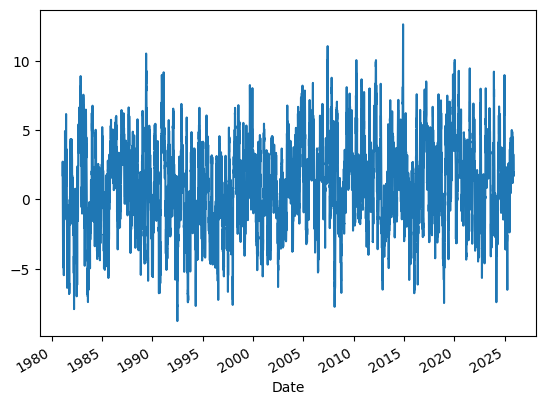

In [85]:
apples_sharpe = sharpe_ratio(apple)

apples_sharpe

test = apple['Close'].pct_change().rolling(30).apply(sharpe_ratio)


test.plot()

## How would I calculate Beta

$$
\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}
$$


In [89]:
end = pd.Timestamp.today().normalize()
start = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

apple_returns = apple['log_returns']
spy_returns =  data['SPY']['log_returns']

apple_returns = apple_returns[apple_returns.index > start]
spy_returns = spy_returns[spy_returns.index > start]

co_variance = np.cov(apple_returns, spy_returns)[0,1]


beta = co_variance / np.var(spy_returns)
beta

1.2015067165902327

In [46]:
apple_returns = apple_returns[apple_returns.index > start]
# spy_returns = spy_returns[spy_returns.index > start]


In [69]:
apple_returns
apple_returns

Date
2020-01-02    0.022816
2020-01-03   -0.009722
2020-01-06    0.007968
2020-01-07   -0.004703
2020-01-08    0.016086
                ...   
2025-11-14   -0.001978
2025-11-17   -0.018171
2025-11-18   -0.000075
2025-11-19    0.004188
2025-11-20   -0.008601
Name: returns, Length: 1481, dtype: float64

In [81]:
np.log(apple['Close'] / apple['Close'].shift(1)).dropna()

Date
1980-12-15   -0.053581
1980-12-16   -0.076231
1980-12-17    0.024450
1980-12-18    0.028580
1980-12-19    0.059239
                ...   
2025-11-14   -0.001980
2025-11-17   -0.018338
2025-11-18   -0.000075
2025-11-19    0.004179
2025-11-20   -0.008639
Name: Close, Length: 11327, dtype: float64